In [14]:
## pdf 를 .md 파일로 바꾸면서 페이지마다 페이지 번호 추가 (vlm으로 표 추출한거 삽입 위함)

from pathlib import Path
import fitz  # pymupdf

PDF_DIR = Path("pdf_out")
MD_DIR = Path("final_docs")
MD_DIR.mkdir(exist_ok=True)

def pdf_to_md_with_pages(pdf_path: Path):
    doc = fitz.open(pdf_path)
    lines = []

    for i in range(doc.page_count):
        page = doc.load_page(i)
        text = page.get_text("text")

        lines.append(f"<!-- page: {i+1} -->")
        lines.append(text.strip())
        lines.append("")  # 페이지 간 공백

    out_path = MD_DIR / f"{pdf_path.stem}.md"
    out_path.write_text("\n".join(lines), encoding="utf-8")
    doc.close()
    return out_path

pdfs = sorted(PDF_DIR.glob("*.pdf"))
print("PDF files:", len(pdfs))

for pdf in pdfs:
    md_path = pdf_to_md_with_pages(pdf)
    print("✅ md created:", md_path.name)


PDF files: 89
✅ md created: (사)벤처기업협회_2024년 벤처확인종합관리시스템 기능 고도화 용역사업 .md
✅ md created: (사)부산국제영화제_2024년 BIFF & ACFM 온라인서비스 재개발 및 행사지원시.md
✅ md created: (사）한국대학스포츠협의회_KUSF 체육특기자 경기기록 관리시스템 개발.md
✅ md created: (재)예술경영지원센터_통합 정보시스템 구축 사전 컨설팅.md
✅ md created: 2025 구미 아시아육상경기선수권대회 조직위원회_2025 구미아시아육상경.md
✅ md created: BioIN_의료기기산업 종합정보시스템(정보관리기관) 기능개선 사업(2차).md
✅ md created: KOICA 전자조달_[긴급] [지문] [국제] 우즈베키스탄 열린 의정활동 상하원 .md
✅ md created: 경기도 안양시_호계체육관 배드민턴장 및 탁구장 예약시스템 구축 용역.md
✅ md created: 경기도 평택시_2024년도 평택시 버스정보시스템(BIS) 구축사업.md
✅ md created: 경기도사회서비스원_2024년 통합사회정보시스템 운영지원.md
✅ md created: 경상북도 봉화군_봉화군 재ᄂ

In [21]:
import re
from pathlib import Path

def insert_tables_into_md(md_path: Path, tables_by_page: list):
    text = md_path.read_text(encoding="utf-8", errors="ignore")

    # 🔒 중복 삽입 방지
    if "<!-- VLM_TABLES_INSERTED -->" in text:
        print(f"⏭️ 이미 처리됨, 스킵: {md_path.name}")
        return

    lines = text.splitlines()
    out = []
    i = 0

    page_to_tables = {rec["page"]: rec["tables"] for rec in tables_by_page}
    current_page = None

    while i < len(lines):
        line = lines[i]
        out.append(line)

        m = re.match(r"<!-- page: (\d+) -->", line)
        if m:
            current_page = int(m.group(1))

        # 페이지 블록 끝 조건
        next_is_page = (i+1 < len(lines)) and re.match(r"<!-- page: \d+ -->", lines[i+1])
        is_last_line = (i == len(lines) - 1)

        if (next_is_page or is_last_line) and current_page in page_to_tables:
            out.append("")
            out.append(f"<!-- VLM_TABLES_INSERTED_PAGE_{current_page} -->")

            for t_idx, t in enumerate(page_to_tables[current_page], 1):
                cap = (t.get("caption") or "").strip() or f"표 {t_idx}"
                out.append(f"### [표] {cap}")
                out.append((t.get("markdown") or "").strip())
                out.append("")

        i += 1

    # 전체 처리 마커
    out.append("<!-- VLM_TABLES_INSERTED -->")

    md_path.write_text("\n".join(out), encoding="utf-8")


In [22]:
## vlm 써서 표 있는 페이지 구분하여 md화 시킴

import base64, json
from openai import OpenAI
from pathlib import Path
import fitz  # pymupdf

PDF_DIR = Path("pdf_out")
MD_DIR = Path("final_docs")
MD_DIR.mkdir(exist_ok=True)

client = OpenAI()
MODEL = "gpt-5-mini" 

SYSTEM = """너는 문서 페이지에서 '표'만 정확히 추출하는 도우미다.
규칙:
- 출력은 JSON 하나만.
- 스키마:
  {"tables":[{"caption":"", "markdown":""}]}
- 표가 없으면 {"tables":[]}
- 추측 금지. 보이는 것만.
- 표는 Markdown table로.
"""

def page_to_data_url(page, zoom=2.0):
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
    b64 = base64.b64encode(pix.tobytes("png")).decode()
    return f"data:image/png;base64,{b64}"

def extract_tables_from_page(page):
    data_url = page_to_data_url(page)
    resp = client.responses.create(
        model=MODEL,
        input=[{
            "role": "system",
            "content": [{"type":"input_text","text": SYSTEM}]
        },{
            "role": "user",
            "content": [
                {"type":"input_text","text":"이 페이지의 표만 JSON으로 추출해."},
                {"type":"input_image","image_url": data_url}
            ]
        }]
    )
    return json.loads(resp.output_text)

def extract_tables_from_pdf(pdf_path: Path):
    doc = fitz.open(pdf_path)
    result = []

    for i in range(doc.page_count):
        page = doc.load_page(i)
        tables = extract_tables_from_page(page).get("tables", [])
        if tables:
            result.append({
                "page": i+1,
                "tables": tables
            })
        if (i+1) % 5 == 0:
            print(f"{pdf_path.name}: {i+1}/{doc.page_count}")

    doc.close()
    return result


In [23]:
pdf = pdfs[0]  # 테스트용 1개
md_path = MD_DIR / f"{pdf.stem}.md"

tables = [
    {
        "page": 7,   # 방금 테스트한 페이지
        "tables": tables_json["tables"]  # 미리보기에서 확인한 그 결과
    }
]

insert_tables_into_md(md_path, tables)
print("✅ 테스트 삽입 완료:", md_path.name)


✅ 테스트 삽입 완료: (사)벤처기업협회_2024년 벤처확인종합관리시스템 기능 고도화 용역사업 .md


In [24]:
import re
from pathlib import Path

def insert_tables_into_md(md_path: Path, tables_by_page: list):
    text = md_path.read_text(encoding="utf-8", errors="ignore")

    # 🔒 중복 삽입 방지
    if "<!-- VLM_TABLES_INSERTED -->" in text:
        print(f"⏭️ 이미 처리됨, 스킵: {md_path.name}")
        return

    lines = text.splitlines()
    out = []
    i = 0

    page_to_tables = {rec["page"]: rec["tables"] for rec in tables_by_page}
    current_page = None

    while i < len(lines):
        line = lines[i]
        out.append(line)

        m = re.match(r"<!-- page: (\d+) -->", line)
        if m:
            current_page = int(m.group(1))

        # 페이지 블록 끝 조건
        next_is_page = (i+1 < len(lines)) and re.match(r"<!-- page: \d+ -->", lines[i+1])
        is_last_line = (i == len(lines) - 1)

        if (next_is_page or is_last_line) and current_page in page_to_tables:
            out.append("")
            out.append(f"<!-- VLM_TABLES_INSERTED_PAGE_{current_page} -->")

            for t_idx, t in enumerate(page_to_tables[current_page], 1):
                cap = (t.get("caption") or "").strip() or f"표 {t_idx}"
                out.append(f"### [표] {cap}")
                out.append((t.get("markdown") or "").strip())
                out.append("")

        i += 1

    # 전체 처리 마커
    out.append("<!-- VLM_TABLES_INSERTED -->")

    md_path.write_text("\n".join(out), encoding="utf-8")


In [25]:
from IPython.display import display, Markdown

def preview_tables(tables_json, page_no=None):
    tables = tables_json.get("tables", [])
    if not tables:
        print("❌ 이 페이지에는 표가 인식되지 않았습니다.")
        return

    for i, t in enumerate(tables, 1):
        title = t.get("caption", "").strip() or f"표 {i}"
        header = f"### 📄 Page {page_no} · {title}" if page_no else f"### {title}"
        display(Markdown(header))
        display(Markdown(t["markdown"]))


In [26]:
from pathlib import Path
import fitz

pdf_dir = Path("pdf_test")

# pdf_out 안의 첫 번째 pdf를 그냥 사용 (테스트용)
pdf_path = next(pdf_dir.glob("*.pdf"))

print("선택된 PDF:", pdf_path)

doc = fitz.open(pdf_path)
page_no = 7
page = doc.load_page(page_no - 1)

print(f"📄 page 객체 생성 완료: {page_no}페이지")


선택된 PDF: pdf_test/(사)벤처기업협회_2024년 벤처확인종합관리시스템 기능 고도화 용역사업 .pdf
📄 page 객체 생성 완료: 7페이지


In [27]:
def page_to_data_url(page, zoom=2.0):
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
    b64 = base64.b64encode(pix.tobytes("png")).decode()
    return f"data:image/png;base64,{b64}"

img_url = page_to_data_url(page)
print("🖼️ 페이지 이미지 변환 완료")


🖼️ 페이지 이미지 변환 완료


In [28]:
client = OpenAI()

SYSTEM_PROMPT = """
너는 문서 페이지에서 '표'만 추출하는 도우미다.

규칙:
- 보이는 표만 추출한다 (추측 금지)
- 표는 Markdown table로 변환한다
- 표가 없으면 {"tables": []} 만 반환한다
- 설명 문장은 쓰지 않는다
- JSON만 출력한다

출력 형식:
{
  "tables": [
    {
      "caption": "표 제목 (없으면 빈 문자열)",
      "markdown": "| ... |"
    }
  ]
}
"""

resp = client.responses.create(
    model="gpt-5-mini",
    input=[
        {
            "role": "system",
            "content": [{"type": "input_text", "text": SYSTEM_PROMPT}]
        },
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": f"{page_no}페이지에서 표만 추출해."},
                {"type": "input_image", "image_url": img_url}
            ]
        }
    ]
)

tables_json = json.loads(resp.output_text)
print("✅ VLM 응답 수신")


✅ VLM 응답 수신


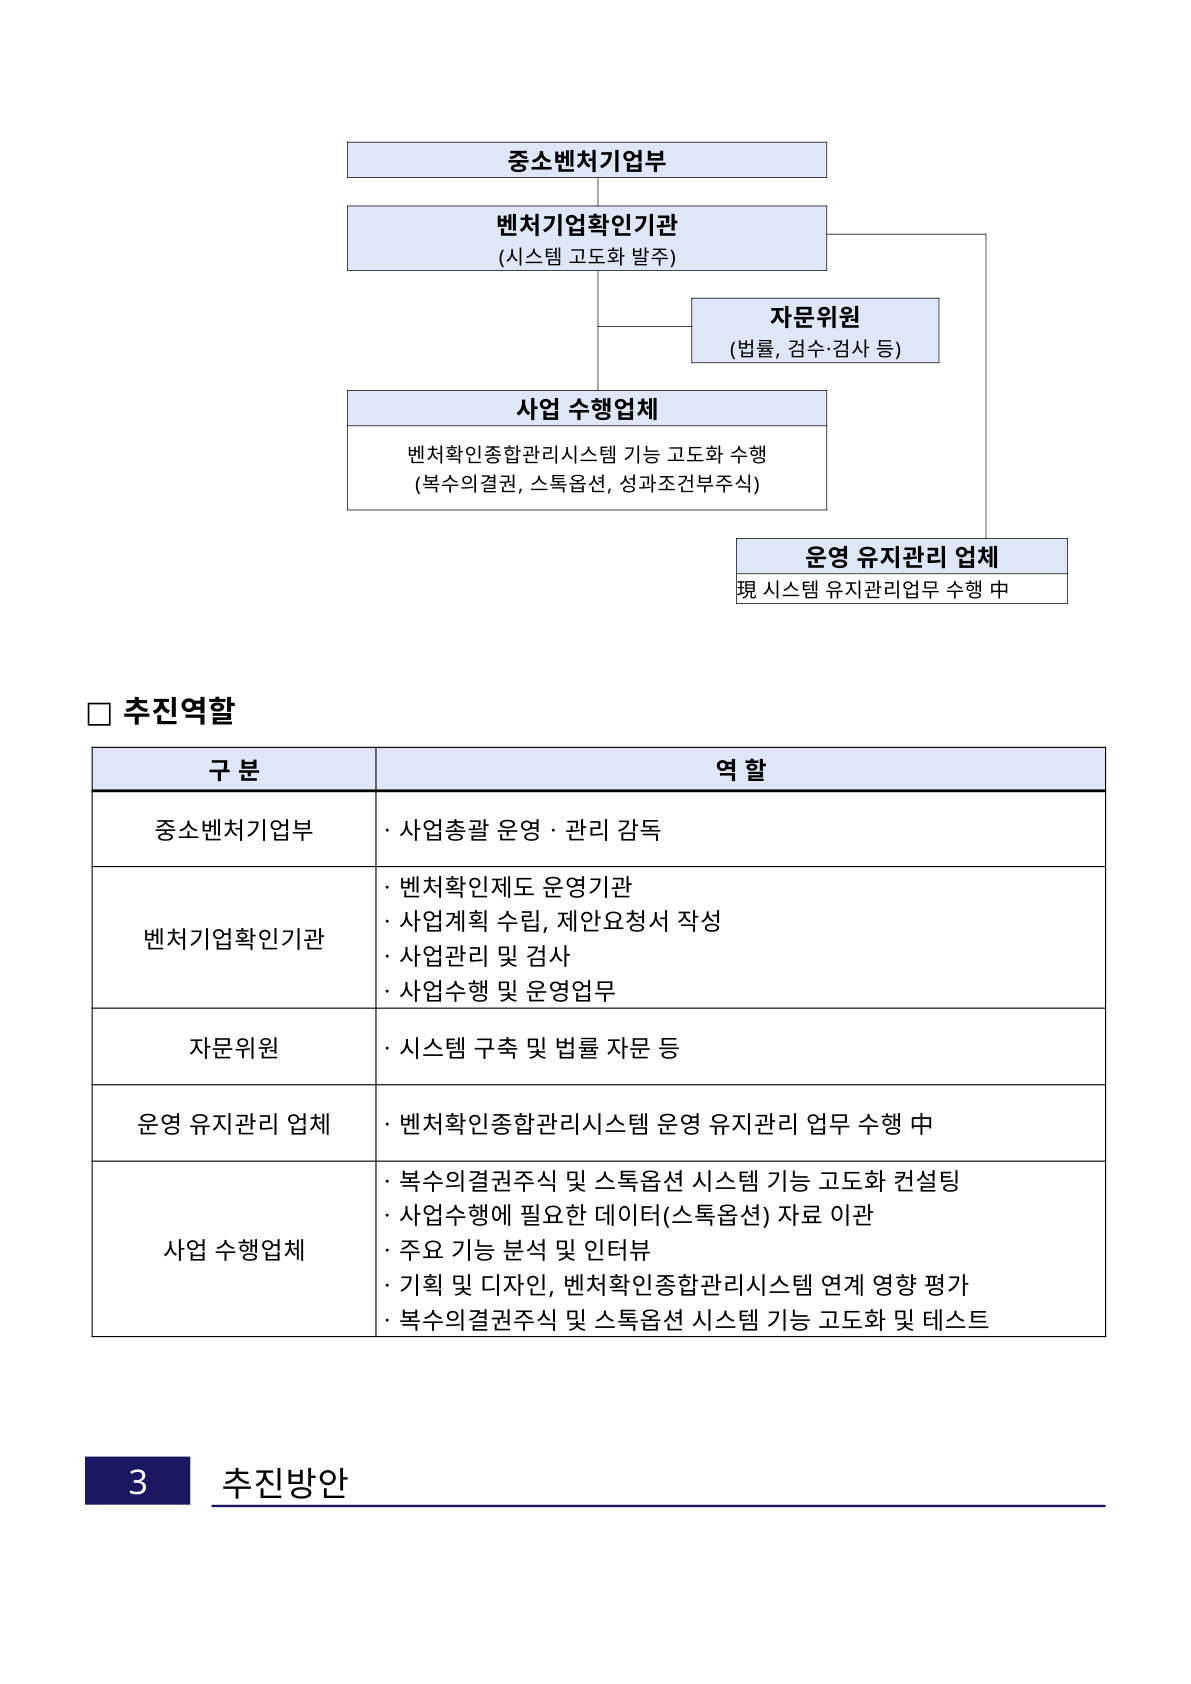

### 📄 Page 7 · 표 1

| 구 분 | 역할 |
|---|---|
| 중소벤처기업부 | · 사업총괄 운영 · 관리 감독 |
| 벤처기업확인기관 | · 벤처확인제도 운영기관<br>· 사업계획 수립, 제안요청서 작성<br>· 사업관리 및 검사<br>· 사업수행 및 운영업무 |
| 자문위원 | · 시스템 구축 및 법률 자문 등 |
| 운영 유지관리 업체 | · 벤처확인종합관리시스템 운영 유지관리 업무 수행 중 |
| 사업 수행업체 | · 복수의결권주식 및 스톡옵션 시스템 기능 고도화 컨설팅<br>· 사업수행에 필요한 데이터(스톡옵션) 자료 이관<br>· 주요 기능 분석 및 인터뷰<br>· 기획 및 디자인, 벤처확인종합관리시스템 연계 영향 평가<br>· 복수의결권주식 및 스톡옵션 시스템 기능 고도화 및 테스트 |

In [31]:
from IPython.display import display, Image, Markdown

def preview_tables(tables_json, page_no=None):
    tables = tables_json.get("tables", [])
    if not tables:
        print("❌ 이 페이지에는 표가 인식되지 않았습니다.")
        return

    for i, t in enumerate(tables, 1):
        title = t.get("caption", "").strip() or f"표 {i}"
        header = f"### 📄 Page {page_no} · {title}" if page_no else f"### {title}"
        display(Markdown(header))
        display(Markdown(t["markdown"]))


# 원본 페이지 이미지 + 표 결과를 같이 보기
display(Image(data=base64.b64decode(img_url.split(",")[1])))
preview_tables(tables_json, page_no=page_no)
